In [1]:
#%% Import packages
import warnings
import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

In [3]:
#%% bulid AIC Model to test the parameters for SARIMA
def SARIMA_AIC(exog, parameters_list, d, D, s):
    """Return parameters and AIC
        
        parameters_list - list with (p, q, P, Q) 
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        results.append([param, aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['Parameters', 'AIC']
    
    result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_table

In [4]:
#%% Read Data
data = pd.read_csv('verkehrsunfaelle.csv')

In [5]:
#%% Check & Clean Data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      2086 non-null   object 
 1   AUSPRAEGUNG                     2086 non-null   object 
 2   JAHR                            2086 non-null   int64  
 3   MONAT                           2086 non-null   object 
 4   WERT                            2002 non-null   float64
 5   VORJAHRESWERT                   1995 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1910 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 146.8+ KB


In [6]:
null = data[data.isnull().T.any()]
data = data.dropna()
data = data[~data['MONAT'].isin(['Summe'])]
data = data[data['AUSPRAEGUNG'].isin(['insgesamt'])]
category = data['MONATSZAHL'].unique()

#Create a new variable 'unfall' to save the collated data
unfall = pd.DataFrame()
unfall['MONAT'] = data['MONAT'].unique()
for i in range(len(category)):
    unfall = pd.merge(unfall, data[data['MONATSZAHL'].isin([category[i]])].loc[:,['MONAT','WERT']], how='left', on='MONAT')
    unfall.rename(columns={'WERT':category[i]},inplace=True)

#Add time series index
unfall['MONAT'] = unfall['MONAT'].apply(lambda x : datetime.strptime(x, '%Y%m'))
unfall = unfall.sort_values(by = 'MONAT')
unfall.set_index('MONAT', inplace=True)
unfall.head()

,Alkoholunfälle,Fluchtunfälle,Verkehrsunfälle
MONAT,,,
2001-01-01,66.0,871.0,3348.0
2001-02-01,49.0,820.0,3148.0
2001-03-01,63.0,962.0,3970.0
2001-04-01,68.0,897.0,3565.0
2001-05-01,85.0,1081.0,4128.0


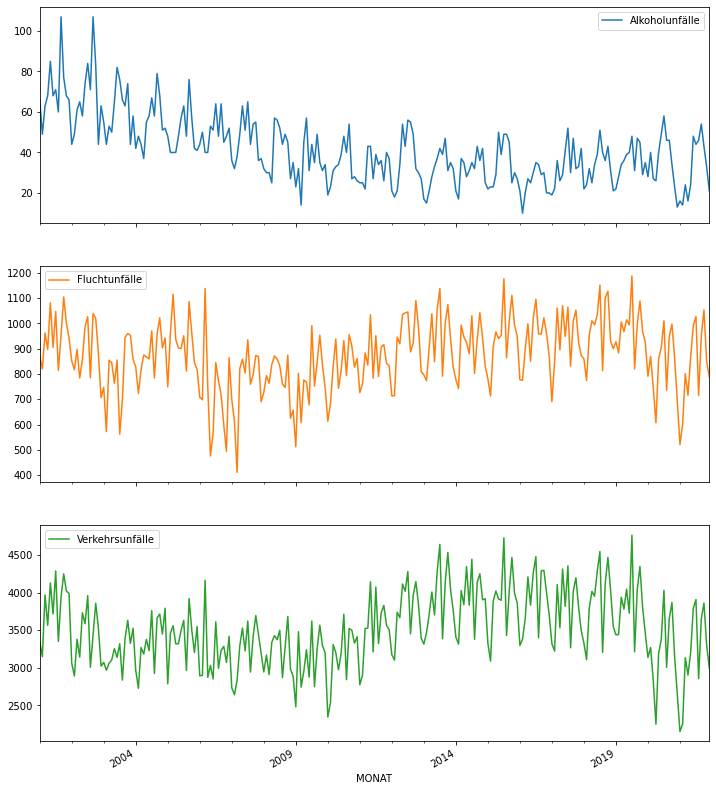

In [10]:
#%% Visualisation of three data sets
unfall.plot(subplots=True, figsize=(12,15))
plt.show()

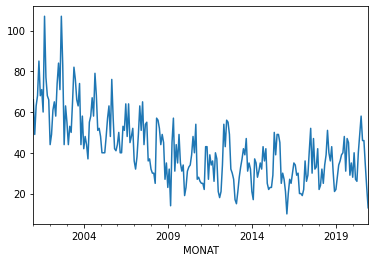

In [19]:
#%%Split data of Alkoholunfälle after 2020 
train = unfall['2000':'2020'][category[0]].copy()
test = unfall['2021'][category[0]].copy()
train.plot()
plt.show()

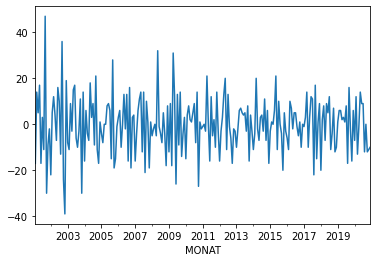

In [13]:
#%%Visualisation of first difference, ACF and PACF
diff1 = train.diff(1).dropna()
diff1.plot()
plt.show()

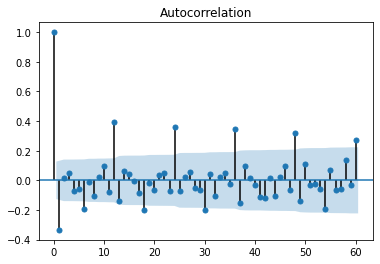

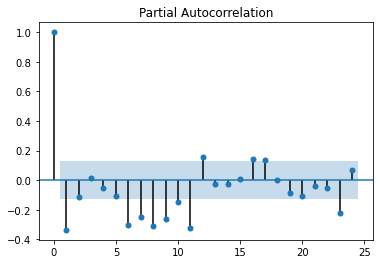

In [28]:
plot_acf(diff1, lags=60)
plot_pacf(diff1)
#for jupyter plot twice bug...use print()
print()

In [21]:
print(acorr_ljungbox(diff1.dropna(), lags=12, boxpierce=True,return_df=True))

      lb_stat     lb_pvalue    bp_stat     bp_pvalue
1   27.120046  1.912049e-07  26.782452  2.276956e-07
2   27.169019  1.259860e-06  26.830613  1.492129e-06
3   27.708811  4.180793e-06  27.359206  4.949926e-06
4   28.895476  8.209033e-06  28.516327  9.800779e-06
5   29.648319  1.729544e-05  29.247303  2.073577e-05
6   38.859173  7.627219e-07  38.152403  1.048867e-06
7   38.885436  2.055324e-06  38.177684  2.803353e-06
8   41.664523  1.565368e-06  40.841457  2.231823e-06
9   41.785790  3.596483e-06  40.957189  5.092483e-06
10  44.218845  3.006691e-06  43.269096  4.451215e-06
11  45.722150  3.620085e-06  44.691310  5.497687e-06
12  85.282855  4.015694e-13  81.953882  1.747407e-12


In [22]:
#%% Apply AIC model, determine parameters
p = range(0,3)
d = 1
q= range(0,3)
P = range(0,3)
D = 1
Q = range(0,2)
s = 12
parameters_list = list(product(p,q,P,Q))
len(parameters_list)

warnings.filterwarnings("ignore") 
AIC_result = SARIMA_AIC(train, parameters_list,d,D,s)

p, q, P, Q = AIC_result['Parameters'][0]

In [24]:
#%%Apply SARIMA, save prediction results
train_model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s)).fit(disp=-1)
print(train_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       Alkoholunfälle   No. Observations:                  240
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -800.501
Date:                              Thu, 27 Oct 2022   AIC                           1611.001
Time:                                      03:06:36   BIC                           1628.126
Sample:                                  01-01-2001   HQIC                          1617.912
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7514      0.068    -11.108      0.000      -0.884      -0.619
ma.L2         -0.15

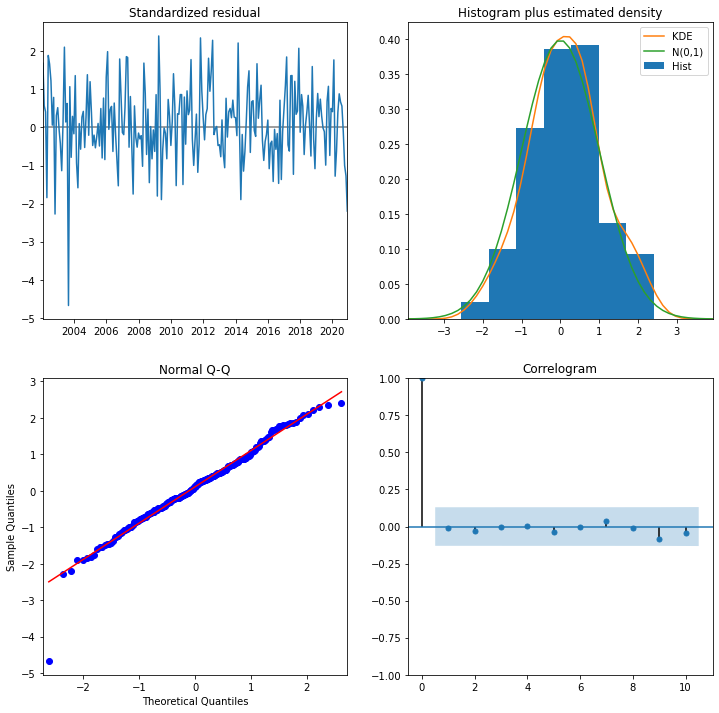

In [27]:
train_model.plot_diagnostics(figsize=(12,12))
#for jupyter plot twice bug...use print()
print()

In [29]:
unfall_alcohol = pd.DataFrame(unfall[category[0]].copy())
unfall_alcohol['SARIMA'] = train_model.fittedvalues.round()
unfall_alcohol['SARIMA'][:s+d] = np.NAN
unfall_alcohol['SARIMA'][test.index[0]:test.index[-1]] = train_model.predict(start=test.index[0], end=test.index[-1]).round()
unfall_alcohol['DEVIATION'] = (unfall_alcohol['SARIMA']-unfall_alcohol[category[0]])

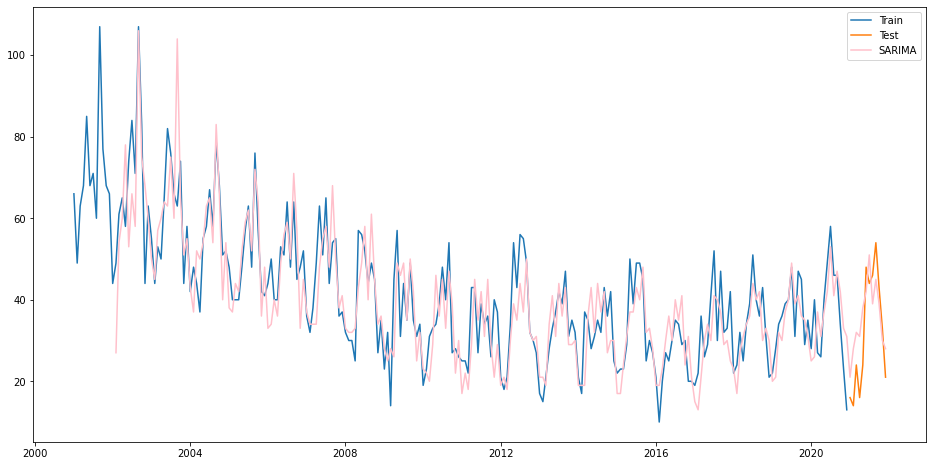

In [30]:
#%% Visualisation of prediction results
plt.figure(figsize=(16,8))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(unfall_alcohol['SARIMA'],color='pink', label='SARIMA')
plt.legend()
plt.show()

In [31]:
print(unfall_alcohol['2021-01'])

            Alkoholunfälle  SARIMA  DEVIATION
MONAT                                        
2021-01-01            16.0    21.0        5.0
